In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file

# Move the kaggle.json file to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set proper permissions

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.68G/3.69G [00:35<00:00, 113MB/s] 
100% 3.69G/3.69G [00:35<00:00, 111MB/s]


In [ ]:
!unzip /content/respiratory-sound-database.zip

Archive:  /content/respiratory-sound-database.zip
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav  
  inflating: Respirato

In [ ]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

audioFilePaths = []
recordingInfoFilePaths = []
for dirname, _, filenames in os.walk('/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files'):
    for filename in filenames:
        fullPath = os.path.join(dirname, filename)
        if filename.endswith("wav"):
            audioFilePaths.append(fullPath)
        elif filename.endswith("txt"):
            recordingInfoFilePaths.append(fullPath)
        #print(os.path.join(dirname, filename))

print(len(audioFilePaths))
print(len(recordingInfoFilePaths))

920
920


In [ ]:
import csv

def extractFilenameWithoutExtension(fullPath):
    fileName = os.path.basename(fullPath)
    fileNameWithoutPath = os.path.splitext(fileName)[0]
    return fileNameWithoutPath

#(fullPaths:string[]) => dict<filename:string, (start, end, hasCrackles, hasWheezes)[]>
def getFileInfoDict(pathList):
    fileInfoDict = {}
    for path in pathList:
        fileNameWithoutPath = extractFilenameWithoutExtension(path)
        infoList = []
        with open(path, 'r') as hFile:
            reader = csv.reader(hFile, delimiter='\t')
            for row in reader:
                startTime = float(row[0])
                endTime = float(row[1])
                hasCrackles = True if int(row[2]) == 1 else False
                hasWheezes = True if int(row[3]) == 1 else False
                infoList.append((startTime, endTime, hasCrackles, hasWheezes))

        fileInfoDict[fileNameWithoutPath] = infoList
    return fileInfoDict

audioFilePathsWithoutExtension = [extractFilenameWithoutExtension(path) for path in audioFilePaths]
fileInfoDict = getFileInfoDict(recordingInfoFilePaths)
#List order is aligned with the order in which the audio clips are extracted
fileInfoList = [fileInfoDict[audioPath] for audioPath in audioFilePathsWithoutExtension]

In [ ]:
import librosa

gSampleRate = 7000

def loadFiles(fileList):
    outputBuffers = []
    for filename in fileList:
        audioBuffer, nativeSampleRate = librosa.load(filename, dtype=np.float32, mono=True, sr=None)
        if nativeSampleRate == gSampleRate:
            outputBuffers.append(audioBuffer)
        else:
        #Linear resampling using numpy is significantly faster than Librosa's default technique
            duration = len(audioBuffer) / nativeSampleRate
            nTargetSamples = int(duration * gSampleRate)
            timeXSource = np.linspace(0, duration, len(audioBuffer), dtype=np.float32)
            timeX = np.linspace(0, duration, nTargetSamples, dtype=np.float32)
            resampledBuffer = np.interp(timeX, timeXSource, audioBuffer)
            outputBuffers.append(resampledBuffer)

    return outputBuffers

audioBuffers = loadFiles(audioFilePaths)

loadFiles is a function for loading audio files, potentially resampling them to a uniform sample rate, and returning the processed audio buffers. The use of linear interpolation for resampling is an optimization choice for speed, as mentioned in the comment.

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

upperCutoffFreq = 3000
cutoffFrequencies = [80, upperCutoffFreq]

#FIR coefficients for a bandpass filter with a window of 80-3000 Hz
highPassCoeffs = signal.firwin(401, cutoffFrequencies, fs=gSampleRate, pass_zero="bandpass")

def applyHighpass(npArr):
    return signal.lfilter(highPassCoeffs, [1.0], npArr)

#Higher gamma results in more aggressive compression
def applyLogCompressor(signal, gamma):
    sign = np.sign(signal)
    absSignal = 1 + np.abs(signal) * gamma
    logged = np.log(absSignal)
    scaled = logged * (1 / np.log(1.0 + gamma)) #Divide by the maximum possible value from compression
    return sign * scaled

#Scales all samples to ensure the peak signal is 1/-1
def normalizeVolume(npArr):
    minAmp, maxAmp = (np.amin(npArr), np.amax(npArr))
    maxEnv = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / maxEnv
    #in place multiply
    npArr *= scale
    return npArr

#Removing the low-freq noise, re-normalizing volume then apply compressor
noiseRemoved = [normalizeVolume(applyHighpass(buffer)) for buffer in audioBuffers]
noiseRemoved = [applyLogCompressor(sig, 30) for sig in noiseRemoved]

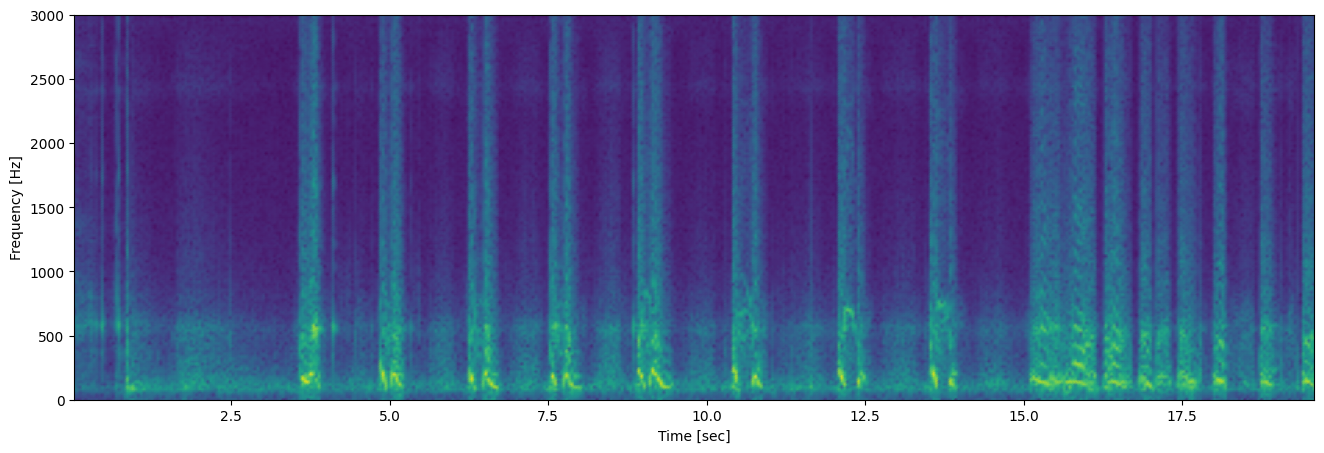

In [ ]:
windowSizeSeconds = 0.05
windowSampleSize = int(gSampleRate * windowSizeSeconds)
selectedSampleIdx = 0

def plotSpectrogram(specData):
    plt.figure(figsize=(16,5))
    #Gamma scaling factor of 0.1 needed to make spectrogram more readable
    plt.pcolormesh(specData[1], specData[0], np.power(specData[2],0.1) , shading='gouraud')
    plt.ylim(0, upperCutoffFreq)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

#(audioBuffers:float[][]) => (frequencies:float[], time(seconds):float[], amplitudes:float[][]))[]
def getSpectrograms(audioBuffers):
    spectrograms = []
    for buffer in audioBuffers:
        freqTable, times, powerSpectrum = signal.spectrogram(buffer, gSampleRate, nperseg=windowSampleSize)
        spectrograms.append((freqTable, times, powerSpectrum))
    return spectrograms

spectrograms = getSpectrograms(noiseRemoved)
plotSpectrogram(spectrograms[selectedSampleIdx])

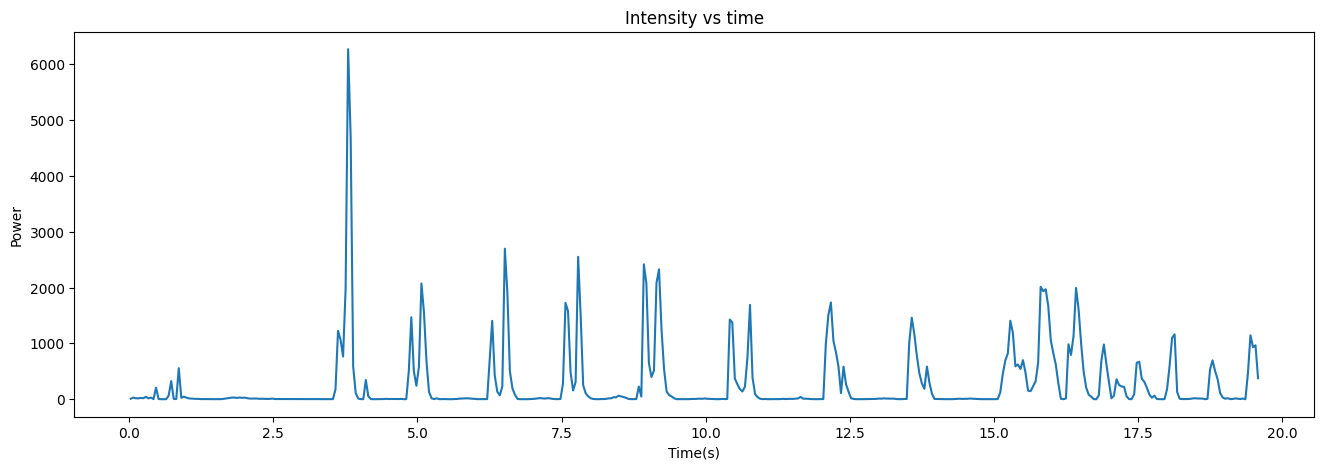

In [ ]:
#(spectrogram:float[][], cutoffFreq(hz):float, plot:bool) => (times:float, amplitudes:float[])
def getPowerEnvelop(spectrogram, cutoff, plot=False):
    frequencies = spectrogram[0]
    timeSlices = spectrogram[1]
    spectrum = spectrogram[2]

    maxInd = np.sum(frequencies <= cutoff)
    truncFreq = frequencies[:maxInd]

    powerEnvelop = []
    for idx, _ in enumerate(timeSlices):
        freqAmplitudes = spectrum[:maxInd,idx]

        powerBins = freqAmplitudes * np.square(truncFreq)
        powerEnvelop.append(sum(powerBins))
    if (plot):
        plt.figure(figsize=(16,5))
        plt.title("Intensity vs time")
        plt.plot(timeSlices, powerEnvelop)
        plt.xlabel("Time(s)")
        plt.ylabel("Power")
        plt.show()

    return (timeSlices, powerEnvelop)

time, amp = getPowerEnvelop(spectrograms[selectedSampleIdx], upperCutoffFreq, True)

getPowerEnvelop processes a spectrogram to compute the power envelope for frequencies up to a specified cutoff, and optionally plots this envelope against time. This is useful for analyzing the energy distribution of an audio signal over time within a specific frequency range.

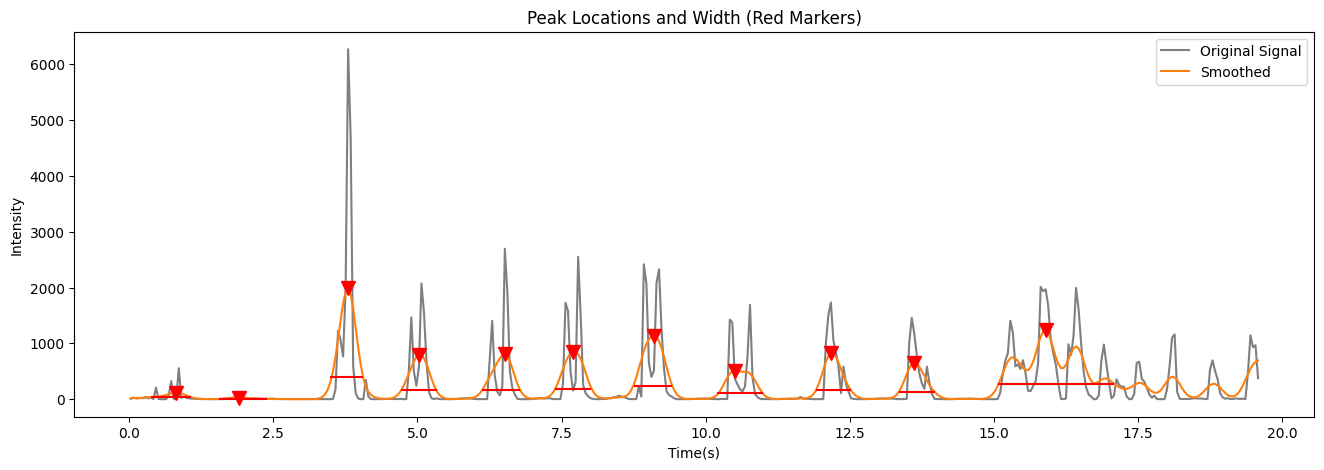

In [ ]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import peak_widths
import math
def findPeaksAndWidthsFromSmoothedCurve(amplitudes,time, sampleInterval, minPeakDuration=0.4, gaussianSmoothingSigma = 3, peakRelHeight=0.8, plot=False):
    smoothed = gaussian_filter1d(amplitudes, gaussianSmoothingSigma)
    minPeakDurationSamples = int(math.ceil(minPeakDuration / sampleInterval))
    peakIndices, _ = find_peaks(smoothed, width=minPeakDurationSamples)
    peakWidthResult = peak_widths(smoothed, peakIndices, peakRelHeight)

    leftPeakTimes = time[np.rint(peakWidthResult[2]).astype(int)]
    rightPeakTimes = time[np.rint(peakWidthResult[3]).astype(int)]
    leftRightBoundaries = list(zip(leftPeakTimes, rightPeakTimes))

    peakTiming = time[peakIndices]
    if plot:
        plt.figure(figsize=(16,5))
        plt.plot(time, amplitudes, color="tab:gray", label="Original Signal")
        plt.plot(time, smoothed, color="tab:orange", label="Smoothed")
        plt.plot(peakTiming, smoothed[peakIndices], "v", color="red", markersize=10)
        plt.hlines(peakWidthResult[1], leftPeakTimes , rightPeakTimes , color="red")
        plt.xlabel("Time(s)")
        plt.ylabel("Intensity")
        plt.title("Peak Locations and Width (Red Markers)")
        plt.legend()
        plt.show()

    return (smoothed, peakTiming, leftRightBoundaries)


_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)

In [ ]:
#Calulate power envelop from sepctrogram
#(time(s):float[], amp:float[])
powerEnvelops = [getPowerEnvelop(spectrogram, upperCutoffFreq, False) for spectrogram in spectrograms]

In [ ]:
from sklearn.model_selection import train_test_split

trainIndices, testIndices = train_test_split(range(len(recordingInfoFilePaths)), test_size=0.2, random_state=0xDEADBEEF)

def multiIndexList(sourceList, indices):
    return [obj for idx, obj in enumerate(sourceList) if idx in indices]

trainFileNames = multiIndexList(audioFilePathsWithoutExtension, trainIndices)
testFileNames = multiIndexList(audioFilePathsWithoutExtension, testIndices)

In [ ]:
#Peak identification from power envelop
#(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[])[]
peakData = [findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds) for time, amp in powerEnvelops]
trainPeakData =  multiIndexList(peakData, trainIndices)
testPeakData =  multiIndexList(peakData, testIndices)

In [ ]:
#Compare the difference between the middle of the detected cycle and the middle of the closest hand-annotated cycle
#Repeat for the left/right boundaries as well
#This will be used to fudge the boundaries to tune the left/right padding values.
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from scipy.sparse import csr_matrix

#(handAnnotatedCentres: float(seconds)[], autoExtractedCentes:float(seconds)[]) => (handAnnotatedIndices:int[], autoExtractedIndices:int[])
#matches the auto-extracted centres with the hand-annotated centres. Each point can only be matched once
#(i.e. one hand-annotated centre will not be matched with more than 1 auto-extracted centre)
def bipartiteMatchWithClosestCentres(handAnnotatedCentres, autoExtractedCentes):
    nRows = len(autoExtractedCentes)
    nCols = len(handAnnotatedCentres)
    weights = np.zeros((nRows, nCols))

    handAnnotatedArr = np.array(handAnnotatedCentres)
    #compute euclidean distance (1-D)
    for row, extractedCentre in enumerate(autoExtractedCentes):
        #Add 1 since the bipartite match requires non-zero weights
        distVec = np.abs(np.subtract(handAnnotatedArr, extractedCentre)) + 1
        weights[row, :] = distVec

    weightsCSR = csr_matrix(weights)

    matchedRows, matchedCols = min_weight_full_bipartite_matching(weightsCSR)
    #(handAnnotatedIndices:int[], autoExtractedIndices:int[])
    return (matchedCols, matchedRows)

In [ ]:
def calculateBoundaryError(audioFileName, autoDetectedPeaks, paddingTime):
    leftBoundaryDiff = []
    rightBoundaryDiff = []
    centreDiffList = []

    for filename, autoPeakInfo in zip(audioFileName, autoDetectedPeaks):
        #Get boundaries from hand-annotated cycles
        handAnnotatedInfo = fileInfoDict[filename]
        handAnnLeft = np.array([info[0] for info in handAnnotatedInfo])
        handAnnRight = np.array([info[1] for info in handAnnotatedInfo])
        handAnnCentre = np.array([(info[0] + info[1]) * 0.5 for info in handAnnotatedInfo])

        #Get centres form automatically extracted cycles
        leftRightBoundaries = autoPeakInfo[2]
        autoLeft = np.array([left - paddingTime[0] for left, _ in leftRightBoundaries])
        autoRight = np.array([right + paddingTime[1] for _, right in leftRightBoundaries])
        autoCentre = np.array([0.5 * (left + right) for left, right in zip(autoLeft, autoRight)])

        #Min. Bipartite Match the centres to pair the most appropriate auto-extracted centre to a hand-annotated centre
        handAnnIndices, autoExtractedIndices = bipartiteMatchWithClosestCentres(handAnnCentre, autoCentre)

        #Now compute the diff. for each cycle extracted from peak-detection.
        #diff from ground truth (<ground-truth> - <peak-detection-method>),
        #-ve values mean the peak detection method detects later than the ground truth (appear right on the graphs)
        leftDiff = np.subtract(handAnnLeft[handAnnIndices], autoLeft[autoExtractedIndices])
        rightDiff = np.subtract(handAnnRight[handAnnIndices], autoRight[autoExtractedIndices])
        centreDiff = np.subtract(handAnnCentre[handAnnIndices], autoCentre[autoExtractedIndices])

        leftBoundaryDiff += leftDiff.tolist()
        rightBoundaryDiff += rightDiff.tolist()
        centreDiffList += centreDiff.tolist()

    return (leftBoundaryDiff, rightBoundaryDiff, centreDiffList)

#Values to be iteratively fine-tuned using the hand-annotated data via the method shown below
paddingTimeInit = (0.305, 1.391) #Note, this has already been refined by the optimizer

boundaryDiff = calculateBoundaryError(trainFileNames, trainPeakData, paddingTimeInit)

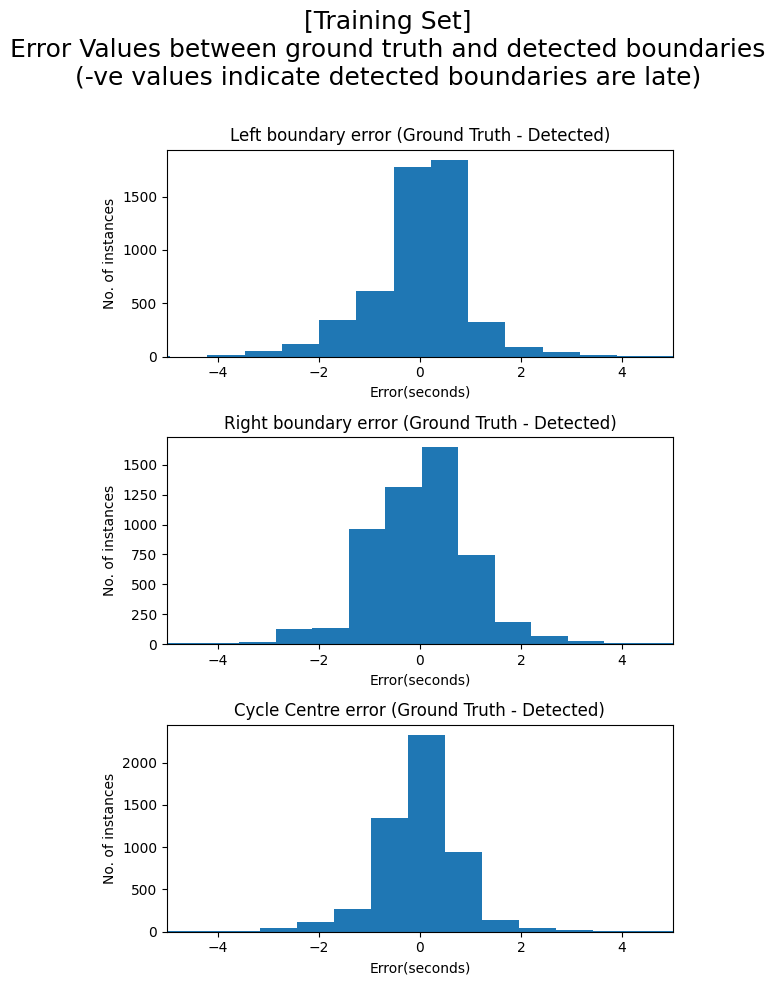

-Mean Errors-
Left Boundary:-0.01898350607615466
Right Boundary:-0.010254869025114794
Centre:-0.0146191875506347


In [ ]:
def plotBoundaryErrorSummary(overallCaption, leftBoundaryDiff, rightBoundaryDiff, centreDiffList):
    nBins = 50
    fig, axs = plt.subplots(3, figsize=(6,10))
    fig.suptitle(
        overallCaption +
        '\nError Values between ground truth and detected boundaries\n(-ve values indicate detected boundaries are late)\n'
        , fontsize=18
    )

    axs[0].hist(leftBoundaryDiff, nBins)
    axs[0].set_title("Left boundary error (Ground Truth - Detected)")
    axs[0].set_xlim([-5, 5])

    axs[1].hist(rightBoundaryDiff, nBins)
    axs[1].set_title("Right boundary error (Ground Truth - Detected)")
    axs[1].set_xlim([-5, 5])

    axs[2].hist(centreDiffList, nBins)
    axs[2].set_title("Cycle Centre error (Ground Truth - Detected)")
    axs[2].set_xlim([-5, 5])

    for ax in axs.flat:
        ax.set(xlabel='Error(seconds)', ylabel='No. of instances')

    plt.tight_layout()
    plt.show()

    print("-Mean Errors-\nLeft Boundary:{0}\nRight Boundary:{1}\nCentre:{2}"
          .format(np.mean(leftBoundaryDiff), np.mean(rightBoundaryDiff),np.mean(centreDiffList)))

plotBoundaryErrorSummary("[Training Set]", *boundaryDiff)

In [ ]:
from scipy.optimize import minimize

def boundaryErrorObj(leftRight):
    leftDiff, rightDiff, _ = calculateBoundaryError(trainFileNames, trainPeakData, leftRight)
    return np.abs(np.sum(leftDiff)) + np.abs(np.sum(rightDiff)) #i.e. make the means as close to 0 as possible

#optimalPaddingRes = minimize(boundaryErrorObj, paddingTimeInit, method=’BFGS’,  options={'disp':True, 'maxiter':1})
#optimalPadding = optimalPaddingRes.x
optimalPadding = paddingTimeInit #Value already optimized, commented lines above to save time.
print(optimalPadding)

(0.305, 1.391)


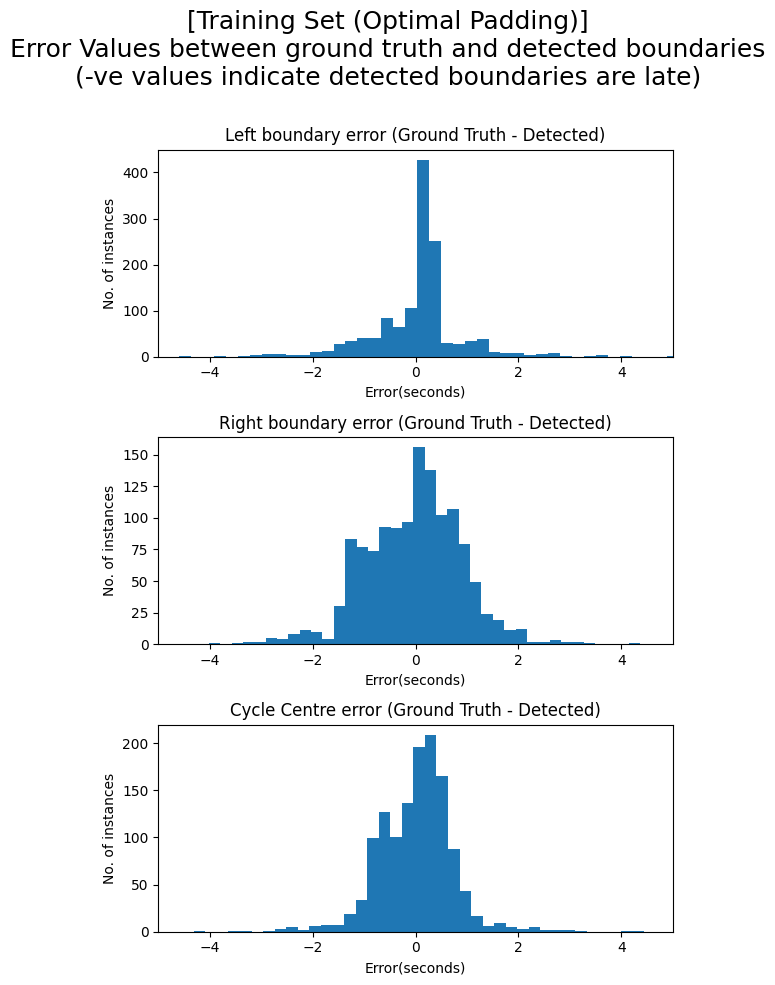

-Mean Errors-
Left Boundary:0.06858995077663504
Right Boundary:-0.028243480638809933
Centre:0.020173235068912554


In [ ]:
boundaryDiffOptimal = calculateBoundaryError(testFileNames, testPeakData, optimalPadding)
plotBoundaryErrorSummary("[Training Set (Optimal Padding)]", *boundaryDiffOptimal)

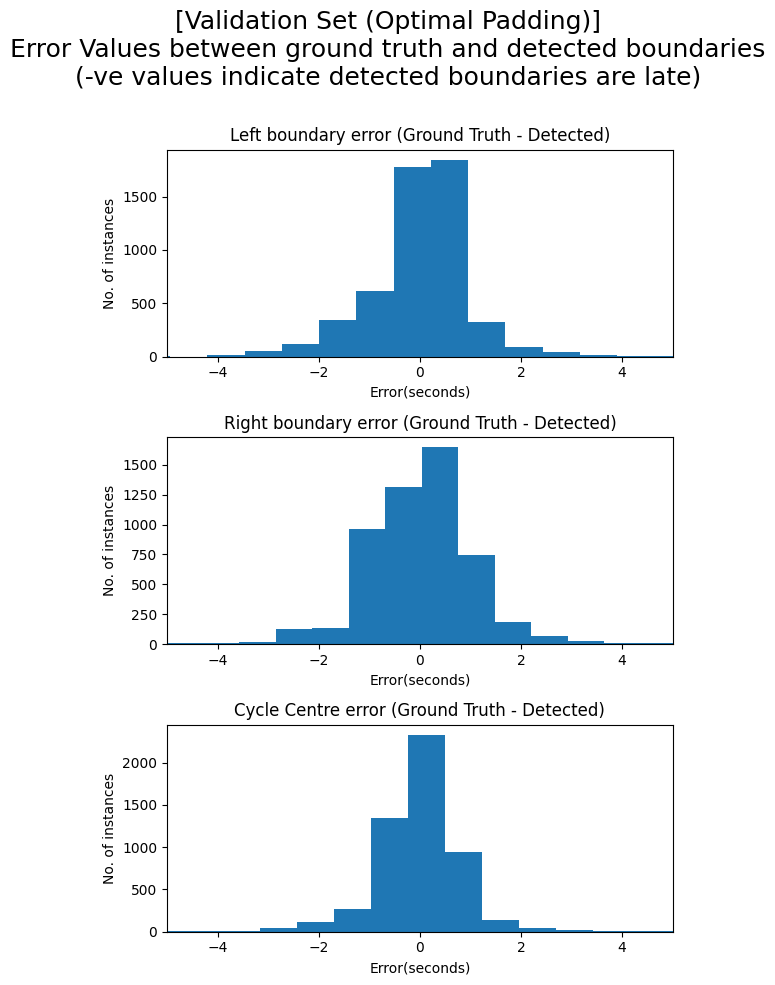

-Mean Errors-
Left Boundary:-0.01898350607615466
Right Boundary:-0.010254869025114794
Centre:-0.0146191875506347


In [ ]:
boundaryDiffOptimalValidation = calculateBoundaryError(trainFileNames, trainPeakData, optimalPadding)
plotBoundaryErrorSummary("[Validation Set (Optimal Padding)]", *boundaryDiffOptimalValidation)

No. of cycles from Hand Annotation:6898
No. of cycles from Peak Detection:10089
95th Percentile of Peak Detection Cycle Lengths:3.84s


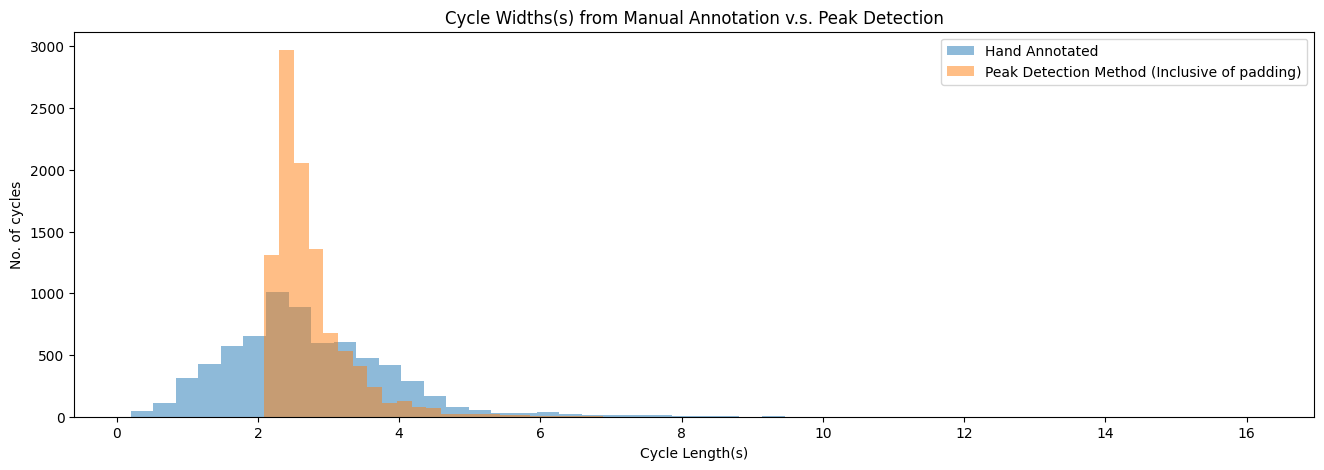

In [ ]:
#Comparison between distribution of detected cycle times.
handAnnotatedWidths = []
for _, cycleInfoList in fileInfoDict.items():
    for cycleInfo in cycleInfoList:
        handAnnotatedWidths.append(cycleInfo[1] - cycleInfo[0])

peakDetectionWidths = []
for peaks in peakData:
    paddingOffset = sum(optimalPadding) #The times are before the left/right pads are added to the sample, re-add pad to get actual extracted length
    for leftRightBoundary in peaks[2]:
        peakDetectionWidths.append(leftRightBoundary[1] - leftRightBoundary[0] + paddingOffset)

print("No. of cycles from Hand Annotation:{0}".format(len(handAnnotatedWidths)))
print("No. of cycles from Peak Detection:{0}".format(len(peakDetectionWidths)))
print("95th Percentile of Peak Detection Cycle Lengths:{:.2f}s".format(np.percentile(peakDetectionWidths, 95)))

nBins = 50
plt.figure(figsize=(16,5))
plt.hist(handAnnotatedWidths, nBins, alpha=0.5, label='Hand Annotated')
plt.hist(peakDetectionWidths, nBins, alpha=0.5, label='Peak Detection Method (Inclusive of padding)')
plt.title("Cycle Widths(s) from Manual Annotation v.s. Peak Detection")
plt.ylabel("No. of cycles")
plt.xlabel("Cycle Length(s)")
plt.legend(loc='upper right')
plt.show()

In [ ]:
def clamp(val, lowerInclusive, upperInclusive):
    if val > upperInclusive:
        return upperInclusive
    elif val < lowerInclusive:
        return lowerInclusive
    else:
        return val

#(timeSegments:(left_seconds:float, right_seconds:float), audioSamples:float[], sampleRate:int) => float[][]
def sliceAudio(timeSegments, audioSamples, sampleRate):
    maxSampleIdx = len(audioSamples) - 1
    segments = []
    for boundaries in timeSegments:
        left = clamp(int(boundaries[0] * sampleRate), 0, maxSampleIdx)
        right = clamp(int(boundaries[1] * sampleRate), 0, maxSampleIdx)
        segments.append(audioSamples[left:right])
    return segments

#(rawAudio:float[],
# peakInfo:(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[]),
# padding:(left:float, right:float),
# sampleRate:int)
#   => (audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])
def extractAudioWithPeakInfo(rawSignal, peakInfo, padding, sampleRate):
    maxSampleIdx = len(rawSignal) - 1
    maxTime = maxSampleIdx * sampleRate
    leftPadding, rightPadding = padding
    leftRightBoundaries = [(clamp(left - leftPadding, 0, maxTime), clamp(right + rightPadding, 0, maxTime)) for left, right in peakInfo[2]]
    audioSegments = sliceAudio(leftRightBoundaries, rawSignal, sampleRate)
    return (audioSegments, peakInfo[1], leftRightBoundaries)

#Get sample slices
#(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[]
extractedAudioClips = [extractAudioWithPeakInfo(signal, peakInfo, optimalPadding,gSampleRate) for signal, peakInfo in zip(noiseRemoved, peakData)]

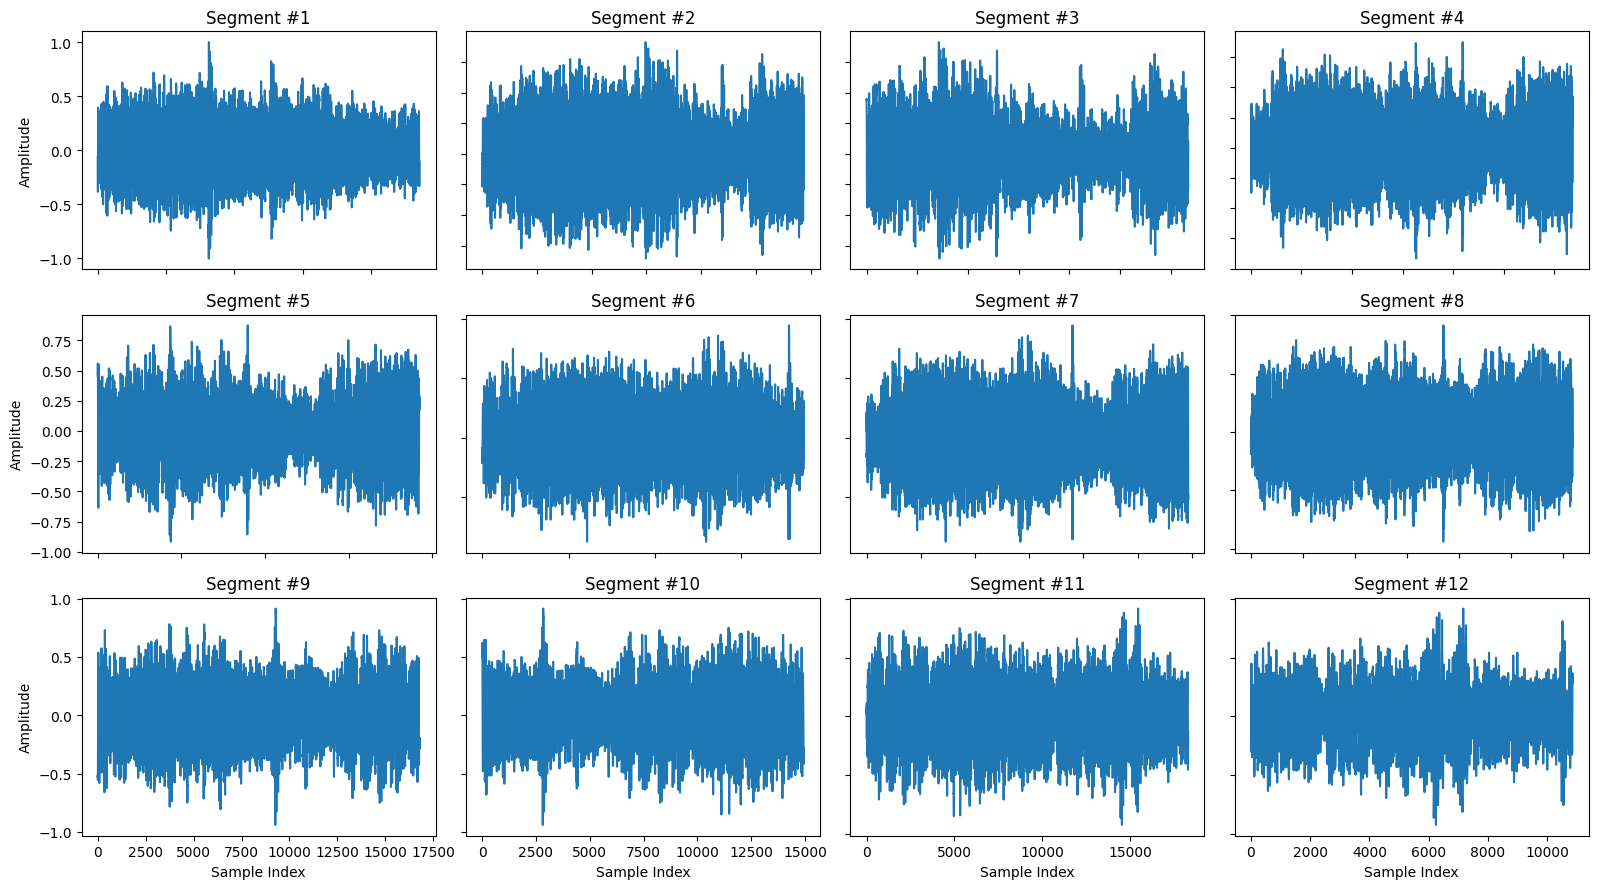

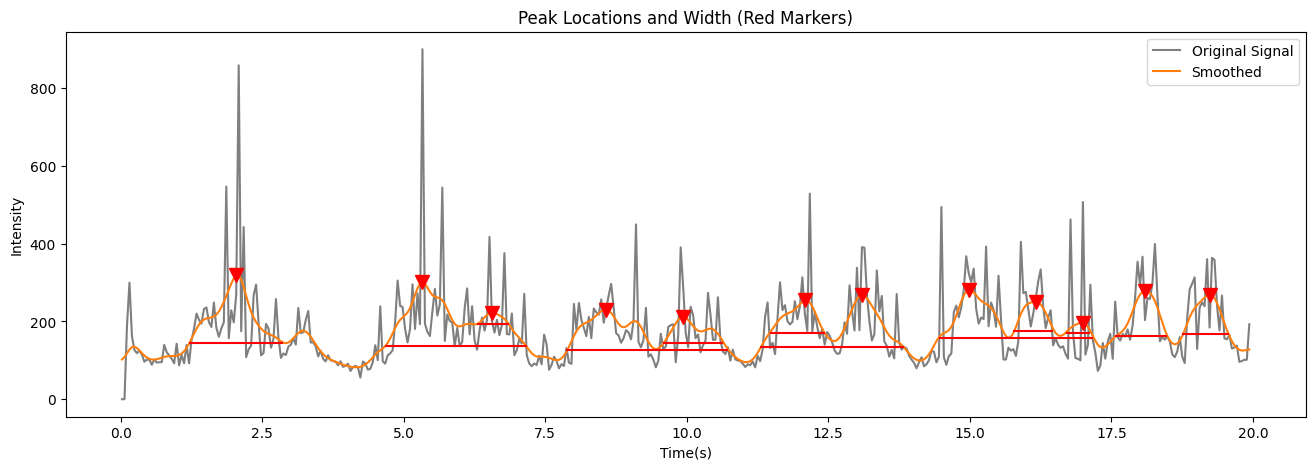

Original


In [ ]:
def plotAllSamples(audioSegments):
    nPlots = len(audioSegments)
    cols = int(math.ceil(math.sqrt(nPlots)))
    rows = math.ceil(nPlots / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(16,9))
    for idx, sample in enumerate(audioSegments):
        row = idx // cols
        col = idx % cols
        ax = axs[row, col]
        ax.plot(sample)
        ax.set_title("Segment #{0}".format(idx + 1))

    for ax in axs.flat:
        ax.set(xlabel='Sample Index', ylabel='Amplitude')

    for ax in axs.flat:
        ax.label_outer()

    plt.tight_layout()
    plt.show()

#plotAllSamples(onlyPeaks)
idx = 19
selectedClip = extractedAudioClips[idx][0]
plotAllSamples(selectedClip)
time, amp = getPowerEnvelop(spectrograms[idx], upperCutoffFreq, False)
_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)
print("Original")
#ipd.display(ipd.Audio(audioBuffers[idx], rate=gSampleRate))
#for i in range(len(selectedClip)):
 #   print("Segment #{0}".format(i + 1))
  #  ipd.display(ipd.Audio(selectedClip[i], rate=gSampleRate))

In [ ]:
#(containingRegion:(left:float,right:float), targetRegion:(left:float,right:float)) => overlapFrac(0-1):float
def getOverlapFrac(containingRegion, targetRegion):
    overlap = max(0, min(containingRegion[1], targetRegion[1]) - max(containingRegion[0], targetRegion[0]))
    overlapFrac = overlap / (targetRegion[1] - targetRegion[0])
    return overlapFrac

def fracOfSampleCovered(groundTruth, autoDetectedWindow):
    overlap = max(0, min(groundTruth[1], autoDetectedWindow[1]) - max(groundTruth[0], autoDetectedWindow[0]))
    fracOfSampleCovered = overlap / (groundTruth[1] - groundTruth[0])
    return fracOfSampleCovered

#Applying labels to auto-extracted data
#(hand-annotated-labels:(start, end, hasCrackles, hasWheezes)[], auto-extracted-segments:(left,right)[], minOverlapFrac(0-1):float) =>
#transfered-labels:(left,right, hasCrackles, hasWheezes)[]
#Any segment where the overlap ratio with a hand annotated segment is more than <minOverlapFrac> will have the crackles/wheezes label applied
#minOverlapFrac is defined as the intersection between the hand-annotated segment and auto-detected segment, divided by the size of the auto-detected segment
def transferLabelToExtractedSegment(handAnnotation, automaticSegmentTimes, minOverlapFrac):
    transferredLabels = []
    handAnnotatedSegments = [(left, right) for left, right, _ , _ in handAnnotation]
    handAnnotatedLabels = [(hasCrackles, hasWheezes) for _, _, hasCrackles, hasWheezes in handAnnotation]
    for autoSegment in automaticSegmentTimes:
        overlapFractions = [getOverlapFrac(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        fracOfAnnSampleCovered = [fracOfSampleCovered(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        allSelectedLabels = [labels if (oFrac > minOverlapFrac or sFrac > minOverlapFrac) else (False, False) for oFrac, sFrac, labels in zip(overlapFractions,fracOfAnnSampleCovered, handAnnotatedLabels)]
        hasCrackles = any([bCrackles for bCrackles, _ in allSelectedLabels])
        hasWheezes = any([bWheezes for _, bWheezes in allSelectedLabels])
        transferredLabels.append((*autoSegment, hasCrackles, hasWheezes))
    return transferredLabels

#illustrative purposes
testIdx = 0
handAnnotations = fileInfoList[testIdx]
autoExtractedSegments = extractedAudioClips[testIdx][2]
print(handAnnotations)
#print(autoExtractedSegments)
print(transferLabelToExtractedSegment(handAnnotations, autoExtractedSegments, 0.5))

[(1.5389, 4.2494, False, False), (4.2494, 5.4273, False, False), (5.4273, 6.9472, False, False), (6.9472, 8.1821, False, False), (8.1821, 9.6577, False, False), (9.6577, 11.159, False, False), (11.159, 12.748, False, False), (12.748, 14.186, False, False), (14.186, 18.277, False, False), (18.277, 19.632, False, False)]
[(0.07085714285714284, 2.468571428571429, False, False), (1.2550000000000001, 3.7842857142857143, False, False), (3.1847142857142856, 5.450857142857143, False, False), (4.412714285714286, 6.722714285714286, False, False), (5.816142857142857, 8.17, False, False), (7.088, 9.398, False, False), (8.447571428571429, 10.801428571428572, False, False), (9.894857142857143, 12.380285714285714, False, False), (11.605285714285715, 13.915285714285714, False, False), (13.05257142857143, 15.362571428571428, False, False), (14.763, 18.47642857142857, False, False)]


In [ ]:
#Apply annotation transfer to all cycles.

#(handAnnotationList:(start, end, hasCrackles, hasWheezes)[],
# autoSegmentList:(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[],
# minOverlapFrac:float) =>
#    autoSegmentWithLabels(audioClips:float[][], peakTimes:float[], cycleInfo:(float,float, hasCrackles, hasWheezes)[])[]
def transferLabels(handAnnotationList, autoSegmentList, minOverlapFrac):
    autoSegmentWithTransferLabels = []
    for handAnn, autoSeg in zip(handAnnotationList,autoSegmentList):
        xferredLabels = transferLabelToExtractedSegment(handAnn, autoSeg[2], minOverlapFrac)
        autoSegmentWithTransferLabels.append((autoSeg[0], autoSeg[1], xferredLabels))
    return autoSegmentWithTransferLabels

minOverlapFrac = 0.5
transferredLabels = transferLabels(fileInfoList, extractedAudioClips, minOverlapFrac)

In [ ]:
nAudioClips = len(fileInfoList)
indices = range(0, nAudioClips)

trainIndices, testIndices = train_test_split(indices, test_size=0.2, random_state=0xDEADBEEF)

#Normalizes all spectrograms on a per spectrogram basis
#(segmentsWithLabels:(audioClips:float[][], peakTimes:float[], cycleInfo:(float,float, hasCrackles, hasWheezes)[])[],
# windowSize(seconds):float, sampleRate:int) =>
#    (spectrogram:float[][][], labels(hasCrackles, hasWheezes)[])[]
def getCorrespondingSpectroGrams(segmentsWithLabels, windowSize, sampleRate, fftSampleWindowSize):
    extractedSpectrogramList = []
    maxSamples = int(windowSize * sampleRate)
    for segmentInfo in segmentsWithLabels:
        clipInfo = []
        for idx, cycleInfo in enumerate(segmentInfo[2]):
            sampleBuffer = np.zeros(maxSamples)
            audioClip = segmentInfo[0][idx]
            #If the extracted clip can fit within the window
            #Simply copy it to the front of the buffer
            if len(audioClip) <= maxSamples:
                sampleBuffer[:len(audioClip)] = audioClip
            #Otherwise, fit the centre of the peak into the buffer
            else:
                nClipSamples = len(audioClip)
                peakTiming = segmentInfo[1][idx]
                left, right = cycleInfo[:2]
                peakIdx = int((peakTiming - left) * sampleRate)
                rightIdx = int(min(peakIdx + (maxSamples // 2), nClipSamples))
                leftIdx = int(max(0, rightIdx - maxSamples))
                sampleBuffer[:(rightIdx - leftIdx)] = audioClip[leftIdx: rightIdx]
            labels = cycleInfo[2:]

            melSpec = librosa.feature.melspectrogram(y=sampleBuffer, sr=sampleRate, n_fft=fftSampleWindowSize)
            melMin = np.min(melSpec)
            melMax = np.max(melSpec)
            melNorm = melSpec / (melMax - melMin)
            clipInfo.append((np.power(melNorm, 0.2), labels))
        extractedSpectrogramList.append(clipInfo)
    return extractedSpectrogramList

modelWindowSize = 4.0 #(seconds) to fit 95th percentile of sample widths
fftWindowSizeSeconds = 0.025
fftWindowSizeSamples = int(fftWindowSizeSeconds * gSampleRate)

trainingSet = multiIndexList(transferredLabels, trainIndices)
testSet = multiIndexList(transferredLabels, testIndices)

trainingLabelledSpectrograms = getCorrespondingSpectroGrams(trainingSet, modelWindowSize, gSampleRate, fftWindowSizeSamples)
testLabelledSpectrograms = getCorrespondingSpectroGrams(testSet, modelWindowSize, gSampleRate, fftWindowSizeSamples)

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


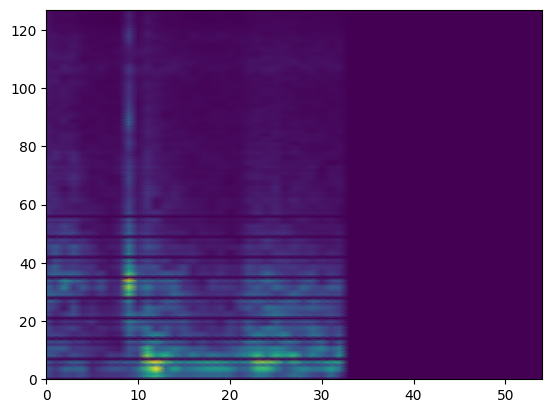

In [ ]:
plt.pcolormesh(trainingLabelledSpectrograms[0][0][0], shading='gouraud')

In [ ]:
#(spectrogram:float[][], labels(hasCrackles, hasWheezes)[])[] -> (flattened_spectrogram[], hasCrackles[], hasWheezes[])
def flattenLabelledData(labelledData):
    flattenedSpectrograms = []
    crackleList = []
    wheezesList = []
    for specLabelPairList in labelledData:
        for idx, specLabelPair in enumerate(specLabelPairList):
            spec, label = specLabelPair
            #flattenedSpectrograms.append(spec.reshape(-1))
            #flattenedSpectrograms.append(spec.flatten('F'))
            flattenedSpectrograms.append(spec)
            crackleList.append(label[0])
            wheezesList.append(label[1])
    #return (flattenedSpectrograms, crackleList, wheezesList)
    return (flattenedSpectrograms, crackleList, wheezesList)

trainSpec1D, trainCrackleLabels, trainWheezeLabels = flattenLabelledData(trainingLabelledSpectrograms)
testSpec1D, testCrackleLabels, testWheezeLabels = flattenLabelledData(testLabelledSpectrograms)

In [ ]:
inputRows, inputCols = trainSpec1D[0].shape

def getLabels(crackleList, wheezeList):
    oneHotLabels = {
        (False, False): [1,0],
        (True, False): [0,1],
        (False, True): [0,1],
        (True, True): [0,1]
    }
    oneHot = []
    for crackleWheezePair in zip(crackleList, wheezeList):
        oneHot.append(oneHotLabels[crackleWheezePair])
    return np.array(oneHot)

trainLabels = getLabels(trainCrackleLabels, trainWheezeLabels)
trainingDataNp = np.reshape(np.array(trainSpec1D), (-1,inputRows, inputCols,1))

testLabels = getLabels(testCrackleLabels, testWheezeLabels)
testDataNp = np.reshape(np.array(testSpec1D), (-1,inputRows, inputCols,1))

In [ ]:
trainTotalPerClass = np.sum(trainLabels, axis=0)
trainClassWeights = np.sum(trainTotalPerClass) / trainTotalPerClass
trainClassWeightsDict = dict(enumerate(trainClassWeights))
print(trainTotalPerClass)
print(trainClassWeightsDict)

[4024 4076]
{0: 2.0129224652087476, 1: 1.9872423945044162}


In [ ]:
import random

def spectorgramTemporalDistortion(spectrogram, col1, col2, offset1, offset2):
    nRows, nCols = spectrogram.shape
    colIndices = np.arange(nCols)
    remappedCols = np.array([0, col1 + offset1, col2 + offset2, nCols - 1])
    originalCols = np.array([0, col1, col2, nCols - 1])
    remappedIndices = np.interp(colIndices, originalCols, remappedCols)

    distorted = np.zeros((nRows, nCols))
    for row in range(nRows):
        distorted[row,:] = np.interp(remappedIndices, colIndices, spectrogram[row,:])
    return distorted

def blotOutRow(spectrogram, row, width):
    nRows, _ = spectrogram.shape
    rowIndices = np.arange(nRows)
    dipBegin = clamp(row - width /2 , 0, nRows - 1)
    dipEnd = clamp(row + width /2, 0, nRows - 1)
    amp = np.array([1,1,0,1,1])
    indices = np.array([0, dipBegin, row, dipEnd, nRows - 1])
    scalingFactor = np.interp(rowIndices, indices, amp)
    blotted = scalingFactor[:,None] * spectrogram
    return blotted

def blotOutCol(spectrogram, col, width):
    _ , nCols = spectrogram.shape
    colIndices = np.arange(nCols)
    dipBegin = clamp(col - width /2 , 0, nCols - 1)
    dipEnd = clamp(col + width /2, 0, nCols - 1)
    amp = np.array([1,1,0,1,1])
    indices = np.array([0, dipBegin, col, dipEnd, nCols - 1])
    scalingFactor = np.interp(colIndices, indices, amp)
    blotted = scalingFactor[None,:] * spectrogram
    return blotted

def offsetSpectrogram(spectrogram, xOffset):
    nRows, nCols = spectrogram.shape
    offsetCopy = np.zeros((nRows, nCols))
    nColsToTake = nCols - xOffset
    offsetCopy[:,xOffset:] = spectrogram[:,:nColsToTake]
    return offsetCopy

def randomlyApplyDistortions(spectrogram, temporalProb, rowBlotProb, colBlotProb, offsetProb):
    acc = spectrogram
    nRows , nCols = spectrogram.shape

    if random.random() < offsetProb:
        offset = int(random.uniform(0, nCols * 0.3))
        acc = offsetSpectrogram(acc, offset)

    if random.random() < temporalProb:
        col1Centre = nCols * 0.25
        col2Centre = nCols * 0.7
        col1 = col1Centre + random.uniform(-nCols * 0.1, nCols * 0.1)
        col2 = col2Centre + random.uniform(-nCols * 0.1, nCols * 0.1)
        offset1 = random.uniform(-nCols * 0.075, nCols * 0.075)
        offset2 = random.uniform(-nCols * 0.075, nCols * 0.075)
        acc = spectorgramTemporalDistortion(acc, col1, col2, offset1, offset2)

    if random.random() < rowBlotProb:
        row = random.uniform(0, nRows - 1)
        width = random.uniform(1, nRows * 0.1)
        acc = blotOutRow(acc, row, width)

    if random.random() < colBlotProb:
        col = random.uniform(0, nCols - 1)
        width = random.uniform(1, nCols * 0.1)
        acc = blotOutCol(acc, col, width)

    return acc

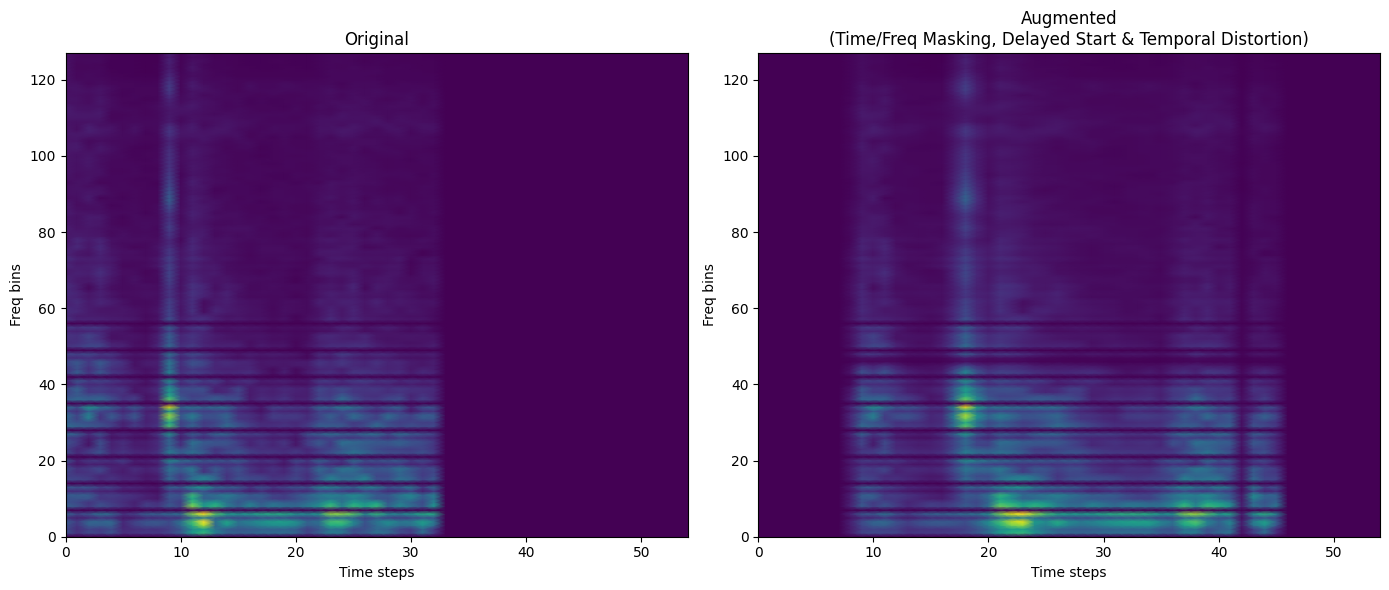

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14,6))

axs[0].set_title("Original")
axs[0].pcolormesh(trainingLabelledSpectrograms[0][0][0], shading='gouraud')

augmented = randomlyApplyDistortions(trainingLabelledSpectrograms[0][0][0], 1, 1, 1, 1)
axs[1].set_title("Augmented\n(Time/Freq Masking, Delayed Start & Temporal Distortion)")
axs[1].pcolormesh(augmented, shading='gouraud')

for ax in axs.flat:
    ax.set(xlabel='Time steps', ylabel='Freq bins')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.utils import Sequence

class SpectrogramSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffleIndices()

    def shuffleIndices(self):
        nSamples = len(self.x)
        indices = np.arange(nSamples)
        np.random.shuffle(indices)
        self.indices = indices

    def on_epoch_end(self):
        self.shuffleIndices()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        startingIdx = idx * self.batch_size
        endingIdx = (idx + 1) * self.batch_size
        selecedIndices = self.indices[startingIdx:endingIdx]

        rawSpectrogramBatch = np.reshape(self.x[selecedIndices], (-1,inputRows, inputCols))
        augmentedSpectrograms = np.array([randomlyApplyDistortions(spectrogram, 0.5, 0.25, 0.25, 0.75) for spectrogram in rawSpectrogramBatch])

        batch_x = np.reshape(augmentedSpectrograms, (-1,inputRows, inputCols, 1))
        batch_y = self.y[selecedIndices]

        return (batch_x, batch_y)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

keras.backend.clear_session()

model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(inputRows, inputCols, 1)),

        layers.Conv2D(96, 7),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 5),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 3),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),
        layers.SpatialDropout2D(0.1),

        layers.Conv2D(256, 3),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),
        layers.SpatialDropout2D(0.1),

        layers.Flatten(),

        layers.Dense(4096),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.5),

        layers.Dense(256),
        layers.LeakyReLU(alpha=0.1),

        layers.Dense(2, activation='Softmax')
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 49, 96)       4800      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 122, 49, 96)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 24, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 20, 128)       307328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 57, 20, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 10, 128)       0         
 g2D)                                                   

In [ ]:
batch_size=128
generator = SpectrogramSequence(trainingDataNp, trainLabels, batch_size)
history = model.fit(
    x=generator,
    epochs=100, #class_weight=trainClassWeightsDict,
    validation_data=(testDataNp, testLabels))

Epoch 1/100
64/64 [==============================] - 23s 132ms/step - loss: 0.6920 - acc: 0.5117 - val_loss: 0.6836 - val_acc: 0.5923
Epoch 2/100
64/64 [==============================] - 6s 91ms/step - loss: 0.6862 - acc: 0.5478 - val_loss: 0.6762 - val_acc: 0.5696
Epoch 3/100
64/64 [==============================] - 7s 103ms/step - loss: 0.6826 - acc: 0.5544 - val_loss: 0.6702 - val_acc: 0.5817
Epoch 4/100
64/64 [==============================] - 6s 95ms/step - loss: 0.6802 - acc: 0.5626 - val_loss: 0.6698 - val_acc: 0.5737
Epoch 5/100
64/64 [==============================] - 6s 94ms/step - loss: 0.6769 - acc: 0.5612 - val_loss: 0.6649 - val_acc: 0.5933
Epoch 6/100
64/64 [==============================] - 6s 92ms/step - loss: 0.6731 - acc: 0.5746 - val_loss: 0.6622 - val_acc: 0.5973
Epoch 7/100
64/64 [==============================] - 6s 94ms/step - loss: 0.6752 - acc: 0.5680 - val_loss: 0.6646 - val_acc: 0.5897
Epoch 8/100
64/64 [==============================] - 7s 101ms/step - loss

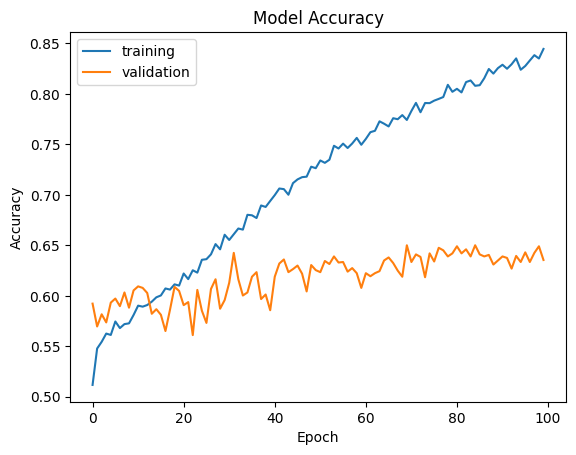

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()